# End-to-end example

We'll show the different functionalities of cluster_experiments, which are:
* MDE calculation in different setups of switchback experiments
* MDE calculation with simple covariate adjustment
* MDE calculation with cupac (adjustment via ML models)
* Inference for all the cases above


## Data generation

We create some pre-experimental data that we could use to run power analysis.

We have a dataframe with orders and customers, each customer may have many orders, and the two target metrics are delivery time and order value.



In [1]:
import random
import datetime

import numpy as np
import pandas as pd
import seaborn as sns


from datetime import timedelta
from cluster_experiments import NormalPowerAnalysis

np.random.seed(42)
random.seed(42)

# Constants
N = 10000  # Number of orders
NUM_CUSTOMERS = 1000  # Unique customers

def generate_customers(num_customers):
    """Generate unique customers with a mean order value based on age."""
    customer_ids = np.arange(1, num_customers + 1)
    customer_ages = np.random.randint(20, 60, size=num_customers)
    mean_order_values = 50 + 0.8 * customer_ages + np.random.normal(0, 10, size=num_customers)

    return pd.DataFrame({
        "customer_id": customer_ids,
        "customer_age": customer_ages,
        "mean_order_value": mean_order_values
    })

def sample_orders(customers, num_orders):
    """Sample customers and generate order-level data."""
    sampled_customers = np.random.choice(customers["customer_id"], size=num_orders)
    return pd.DataFrame({"customer_id": sampled_customers}).merge(customers, on="customer_id", how="left")

def generate_orders(customers, num_orders):
    """Full order generation pipeline using .assign() for cleaner transformations."""
    date_range = pd.date_range(start="2024-01-01", end="2024-03-31", freq='H')
    
    # Generate 100 cities
    cities = [f"City_{i:02d}" for i in range(1, 101)]
    
    def calculate_delivery_time(df):
        # Base delivery time per customer
        base_time = 8 + np.sin(df["customer_id"] / 10)
        
        # Time of day effect (slower during rush hours: 8-9am, 5-7pm)
        hour = df["datetime"].dt.hour
        time_effect = np.where(
            ((hour >= 8) & (hour <= 9)) | ((hour >= 17) & (hour <= 19)),
            1.5,  # 1.5 hours slower during rush hours
            0
        )
        
        # Day of week effect (slower on weekends)
        day_of_week = df["datetime"].dt.dayofweek
        weekend_effect = np.where(day_of_week >= 5, 0.8, 0)  # 0.8 hours slower on weekends
        
        # City effect (some cities have systematically longer delivery times)
        # Extract city number and create varying delivery times
        city_numbers = df["city"].str.extract(r'City_(\d+)')[0].astype(int)
        city_effect = 0.5 * np.sin(city_numbers / 20) + 0.3 * np.cos(city_numbers / 15)
        
        # Random noise
        noise = np.random.normal(0, 0.5, size=len(df))
        
        return base_time + time_effect + 4 * weekend_effect + city_effect + noise

    return (
        sample_orders(customers, num_orders)
        .assign(
            order_value=lambda df: df["mean_order_value"] + np.random.normal(0, 5, size=len(df)),
            datetime=lambda df: pd.to_datetime(np.random.choice(date_range, size=len(df))),
            city=lambda df: np.random.choice(cities, size=len(df)),
        )
        .assign(
            delivery_time=calculate_delivery_time,
            date=lambda df: df["datetime"].dt.date  # Extract date for compatibility
        )
        .drop(columns=["mean_order_value"])  # Remove intermediate column
    )

def plot_mdes(mdes, x_lim=40, y_value=3):
    sns.lineplot(
        data=pd.DataFrame(mdes),
        x="experiment_length",
        y="mde",
    )

    sns.lineplot(
        x=[0, x_lim],
        y=[y_value, y_value],
        color="red",
        linestyle="--",
    )


def get_length_print(mdes, mde_value):
    if any(x["mde"] < mde_value for x in mdes):
        length = min(x["experiment_length"] for x in mdes if x["mde"] < mde_value)
        print(f"Minimum experiment length to detect MDE of {mde_value}: {length}")
        return
    print(f"No MDE below {mde_value} found in the provided data.")

# Run the pipeline
customers = generate_customers(NUM_CUSTOMERS)
experiment_data = generate_orders(customers, N).assign(
    is_weekend=lambda df: df["datetime"].dt.dayofweek >= 5,
    hour_of_day=lambda df: df["datetime"].dt.hour,
)

experiment_data


/var/folders/n0/x7n4w_fs4vz094fp0sjd9mk00000gp/T/ipykernel_11416/441254994.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2024-01-01", end="2024-03-31", freq='H')


,customer_id,customer_age,order_value,datetime,city,delivery_time,date,is_weekend,hour_of_day
0,611,39,72.199186,2024-02-21 08:00:00,City_39,9.268687,2024-02-21,False,8
1,704,23,81.011831,2024-01-26 16:00:00,City_98,8.421502,2024-01-26,False,16
2,243,52,89.979294,2024-03-25 11:00:00,City_34,6.935599,2024-03-25,False,11
3,831,23,65.235192,2024-03-27 09:00:00,City_91,10.286479,2024-03-27,False,9
4,561,58,91.154383,2024-03-29 14:00:00,City_44,8.100706,2024-03-29,False,14
...,...,...,...,...,...,...,...,...,...
9995,280,46,83.915813,2024-01-31 10:00:00,City_23,8.824491,2024-01-31,False,10
9996,538,27,51.848917,2024-01-05 14:00:00,City_44,6.947604,2024-01-05,False,14
9997,685,30,76.810120,2024-02-22 02:00:00,City_38,8.982564,2024-02-22,False,2
9998,156,58,77.046916,2024-03-16 10:00:00,City_49,11.140749,2024-03-16,True,10


## Power analysis

### Day-level split

Assume we run an switchback test randomizing at day level

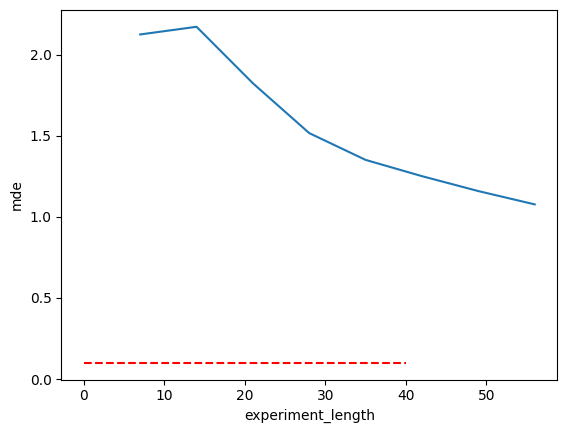

In [2]:
# we want to detect an effect of 0.1 on delivery_time, so we set the mde_value to 0.1
MDE_VALUE = 0.1
EXPERIMENT_LENGTHS = (7, 14, 21, 28, 35, 42, 49, 56)

mde_time_split = NormalPowerAnalysis.from_dict({
    "analysis": "clustered_ols",
    "cluster_cols": ["datetime"],
    "splitter": "switchback",
    "switch_frequency": "24h",
    "target_col": "delivery_time",
    "time_col": "datetime",
})

mdes = mde_time_split.mde_time_line(
    experiment_data,
    powers=[0.8],
    experiment_length=EXPERIMENT_LENGTHS,
    n_simulations=10
)

plot_mdes(mdes, y_value=MDE_VALUE)

In [3]:
get_length_print(mdes, MDE_VALUE)

No MDE below 0.1 found in the provided data.


### 4h-level split

Assume we randomize the treatment at 4h level, we can use the same data as above, but we need to change the switch frequency to 4h.

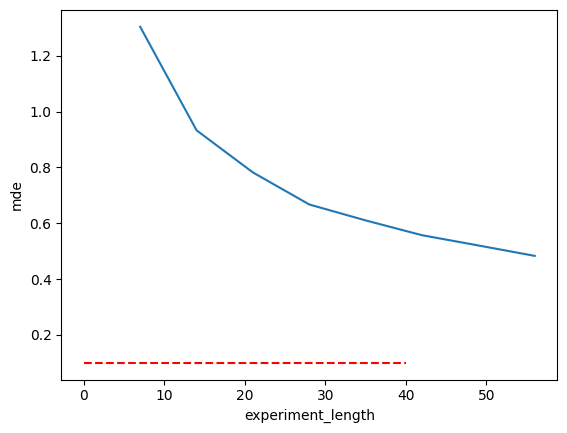

In [4]:
mde_time_split = NormalPowerAnalysis.from_dict({
    "analysis": "clustered_ols",
    "cluster_cols": ["datetime"],
    "splitter": "switchback",
    "switch_frequency": "4h",
    "target_col": "delivery_time",
    "time_col": "datetime",
    "washover": "constant_washover",
    "washover_time_delta": timedelta(minutes=30),
})

mdes = mde_time_split.mde_time_line(
    experiment_data,
    powers=[0.8],
    experiment_length=EXPERIMENT_LENGTHS,
    n_simulations=10
)

plot_mdes(mdes, y_value=MDE_VALUE)

In [5]:
get_length_print(mdes, MDE_VALUE)

No MDE below 0.1 found in the provided data.


### City + 4h-level split

Assume we randomize the treatment at city + 4h level, we can use the same data as above, but we need to add city as a cluster column.

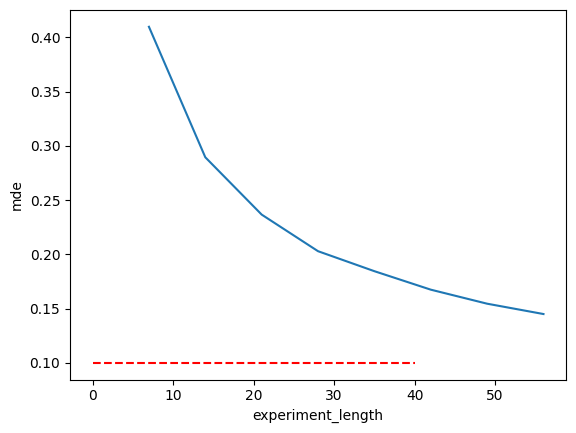

In [6]:
mde_time_split = NormalPowerAnalysis.from_dict({
    "analysis": "clustered_ols",
    "cluster_cols": ["datetime", "city"],
    "splitter": "switchback",
    "switch_frequency": "4h",
    "target_col": "delivery_time",
    "time_col": "datetime",
    "washover": "constant_washover",
    "washover_time_delta": timedelta(minutes=30),
})

mdes = mde_time_split.mde_time_line(
    experiment_data,
    powers=[0.8],
    experiment_length=EXPERIMENT_LENGTHS,
    n_simulations=10
)

plot_mdes(mdes, y_value=MDE_VALUE)

In [7]:
get_length_print(mdes, MDE_VALUE)

No MDE below 0.1 found in the provided data.


is_weekend is a good predictor of delivery time that is not impacted by the treatment. We can use this covariate to adjust our analysis and decrease mde. We see that mde is smaller in this case, because we are using a covariate that is not impacted by the treatment.

In [8]:
mde_variance_reduction = NormalPowerAnalysis.from_dict({
    "analysis": "clustered_ols",
    "cluster_cols": ["datetime", "city"],
    "splitter": "switchback",
    "switch_frequency": "4h",
    "target_col": "delivery_time",
    "time_col": "datetime",
    "covariates": ["is_weekend"],
    "washover": "constant_washover",
    "washover_time_delta": timedelta(minutes=30),
})

In [9]:
mdes = mde_variance_reduction.mde_time_line(
    experiment_data,
    powers=[0.8],
    experiment_length=EXPERIMENT_LENGTHS,
    n_simulations=10
)

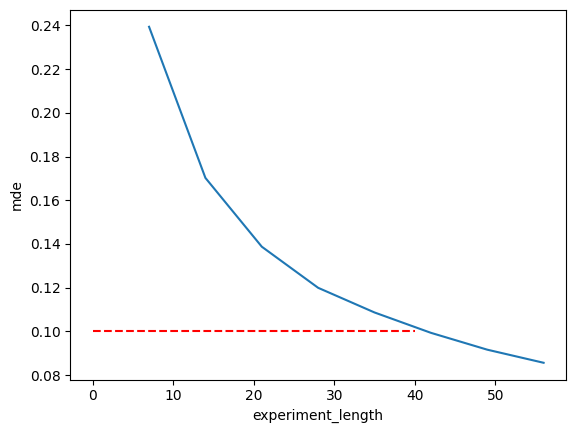

In [10]:
plot_mdes(mdes, y_value=MDE_VALUE)

In [11]:
get_length_print(mdes, MDE_VALUE)

Minimum experiment length to detect MDE of 0.1: 42


This is the last example of power analysis.

We assume data from Feb onwards is used to run the power analysis (it's the data we take as experimental, though it is actually pre-experimental data). Data from Jan is taken as pre-experimental data. We simulate that the experiment happened after Feb. We do this because we need pre-experimental data to train the Cupac Model, which we didn't do before.

We use cupac model with customer id and datetime features (delivery-time has a non-linear relationship with customer id, that's why we don't add it a single covariate). We use the same data as before, but we train the model with pre-experimental data. We see that mde is smaller in this case, because we are using a **better** covariate that is not impacted by the treatment.

In this case we cannot init by dict because we're using cupac, but happy to review a PR that includes this :) In this case we need to create splitter and analysis classes.

In [12]:
cutoff_date = datetime.date(2024, 2, 1)

pre_experiment_df = experiment_data[experiment_data["date"] < cutoff_date]
experiment_df = experiment_data[experiment_data["date"] >= cutoff_date]

In [13]:
from cluster_experiments import SwitchbackSplitter, ClusteredOLSAnalysis, ConstantWashover
from sklearn.ensemble import HistGradientBoostingRegressor


splitter = SwitchbackSplitter(
    cluster_cols=["datetime", "city"],
    switch_frequency="4h",
    time_col="datetime",
    washover=ConstantWashover(
        washover_time_delta=timedelta(minutes=30)
    )
)
ols = ClusteredOLSAnalysis(
    target_col="delivery_time",
    covariates=["estimate_delivery_time"],
    cluster_cols=["datetime", "city"],
)

pwr = NormalPowerAnalysis(
    splitter=splitter,
    analysis=ols,
    cupac_model=HistGradientBoostingRegressor(),
    time_col="datetime",
    target_col="delivery_time",
    features_cupac_model=["customer_id", "is_weekend", "hour_of_day"],
)


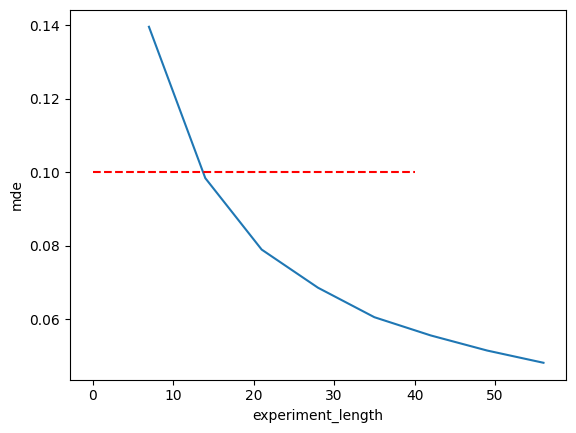

In [14]:
mde_cupac = pwr.mde_time_line(
    experiment_df,
    pre_experiment_df,
    powers=[0.8],
    experiment_length=EXPERIMENT_LENGTHS,
    n_simulations=10,
)

plot_mdes(mde_cupac, y_value=MDE_VALUE)

In [15]:
get_length_print(mde_cupac, MDE_VALUE)

Minimum experiment length to detect MDE of 0.1: 14


## Analysis

Now we run analysis assuming that the experiment run after 2024-03-01 for 3 weeks. We simulate some fake effects (0.0 in order value and 0.1 in delivery time). We use functionalities in cluster_experiments to simulate the experiment.

In [16]:
cutoff_date = datetime.date(2024, 3, 1)

real_experiment_data = experiment_data[experiment_data["date"] >= cutoff_date]
real_pre_experiment_data = experiment_data[experiment_data["date"] < cutoff_date]

from cluster_experiments import ConstantPerturbator


# Add effect on the order value
splitter = SwitchbackSplitter(
    cluster_cols=["datetime", "city"],
    switch_frequency="4h",
    time_col="datetime",
    washover=ConstantWashover(
        washover_time_delta=timedelta(minutes=30)
    )
)

perturbator = ConstantPerturbator(
    target_col="delivery_time",
)

real_experiment_data = splitter.assign_treatment_df(real_experiment_data)
real_experiment_data = perturbator.perturbate(real_experiment_data, average_effect=0.1)

We run the analysis with and without covariate adjustment.

We see that the effect is closer to the true effect when we use covariate adjustment.

In [17]:
from cluster_experiments import AnalysisPlan, HypothesisTest, Variant, SimpleMetric

plan = AnalysisPlan.from_metrics_dict({
    "metrics": [
        {"alias": "AOV", "name": "order_value"},
        {"alias": "delivery_time", "name": "delivery_time"},
    ],
    "variants": [
        {"name": "A", "is_control": True},
        {"name": "B", "is_control": False},
    ],
    "variant_col": "treatment",
    "alpha": 0.05,
    "analysis_type": "clustered_ols",
    "analysis_config": {"cluster_cols": ["city", "datetime"]},
})


We see that CIs contain the true effect, and CIs are pretty big.

In [18]:
# Run the analysis plan
plan.analyze(real_experiment_data).to_dataframe()

,metric_alias,control_variant_name,treatment_variant_name,control_variant_mean,treatment_variant_mean,analysis_type,ate,ate_ci_lower,ate_ci_upper,p_value,std_error,dimension_name,dimension_value,alpha
0,AOV,A,B,82.007654,82.172876,clustered_ols,0.165222,-0.880170,1.210615,0.756737,0.533373,__total_dimension,total,0.05
1,delivery_time,A,B,9.299918,9.452242,clustered_ols,0.152324,0.013381,0.291268,0.031657,0.070891,__total_dimension,total,0.05


Now we use covariate adjustment with is weekend.

In [19]:
plan_covariates = AnalysisPlan.from_metrics_dict({
    "metrics": [
        {"alias": "AOV", "name": "order_value"},
        {"alias": "delivery_time", "name": "delivery_time"},
    ],
    "variants": [
        {"name": "A", "is_control": True},
        {"name": "B", "is_control": False},
    ],
    "variant_col": "treatment",
    "alpha": 0.05,
    "analysis_type": "clustered_ols",
    "analysis_config": {"cluster_cols": ["city", "datetime"], "covariates": ["is_weekend"]},
})

In [20]:
# Run the analysis plan
plan_covariates.analyze(real_experiment_data).to_dataframe()

,metric_alias,control_variant_name,treatment_variant_name,control_variant_mean,treatment_variant_mean,analysis_type,ate,ate_ci_lower,ate_ci_upper,p_value,std_error,dimension_name,dimension_value,alpha
0,AOV,A,B,82.007654,82.172876,clustered_ols,0.167288,-0.878599,1.213175,0.753907,0.533626,__total_dimension,total,0.05
1,delivery_time,A,B,9.299918,9.452242,clustered_ols,0.095147,0.014737,0.175557,0.020385,0.041026,__total_dimension,total,0.05


Now we run analysis using cupac model. We see that the effect in both metrics is closer to the true effect, and the CIs are smaller.

In [21]:
plan_cupac = AnalysisPlan(
    tests=[
        HypothesisTest(
            metric=SimpleMetric(alias="AOV", name="order_value"),
            analysis_type="clustered_ols",
            analysis_config={
                "cluster_cols": ["city", "datetime"],
                "covariates": ["estimate_order_value"],
            },
            cupac_config={
                "cupac_model": HistGradientBoostingRegressor(),
                "features_cupac_model": ["customer_id", "customer_age"],
                "target_col": "order_value",
            },
        ),
        HypothesisTest(
            metric=SimpleMetric(alias="delivery_time", name="delivery_time"),
            analysis_type="clustered_ols",
            analysis_config={
                "cluster_cols": ["city", "datetime"],
                "covariates": ["estimate_delivery_time"],
            },
            cupac_config={
                "cupac_model": HistGradientBoostingRegressor(),
                "features_cupac_model": ["customer_id", "is_weekend", "hour_of_day"],
                "target_col": "delivery_time",
            },
        ),
    ],
    variants=[
        Variant(name="A", is_control=True),
        Variant(name="B", is_control=False),
    ],
    variant_col="treatment",
)

In [22]:
plan_cupac.analyze(
    real_experiment_data,
    real_pre_experiment_data,
).to_dataframe()

,metric_alias,control_variant_name,treatment_variant_name,control_variant_mean,treatment_variant_mean,analysis_type,ate,ate_ci_lower,ate_ci_upper,p_value,std_error,dimension_name,dimension_value,alpha
0,AOV,A,B,82.007654,82.172876,clustered_ols,0.322643,-0.270459,0.915745,0.286331,0.302609,__total_dimension,total,0.05
1,delivery_time,A,B,9.299918,9.452242,clustered_ols,0.107405,0.062609,0.152201,0.000003,0.022856,__total_dimension,total,0.05
